In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from shapely.geometry import Point, LineString
from shapely.geometry import LineString, Point
from scipy.spatial import cKDTree

%matplotlib inline

pd.set_option("display.max_columns", 100)

In [ ]:
# get dataset
# df = gpd.read_file('./road.gpkg', layer='wegvakken')

In [10]:
# df.to_parquet('./wegvakken.parquet')
df.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [ ]:
minx, miny, maxx, maxy = 124457, 445782, 146990, 464462
bbox = (minx, miny, maxx, maxy)

# Crop the GeoDataFrame using the bounding box
ut = df.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
# Optionally, save the cropped GeoDataFrame to a new file
ut.to_parquet('utrecht.parquet')

In [4]:
ut = gpd.read_parquet('./utrecht.parquet')
ut.head()

,objectid,wvk_id,wvk_begdat,jte_id_beg,jte_id_end,wegbehsrt,wegnummer,wegdeelltr,hecto_lttr,bst_code,rpe_code,admrichtng,rijrichtng,stt_naam,stt_bron,wpsnaam,gme_id,gme_naam,hnrstrlnks,hnrstrrhts,e_hnr_lnks,e_hnr_rhts,l_hnr_lnks,l_hnr_rhts,begafstand,endafstand,beginkm,eindkm,pos_tv_wol,wegbehcode,wegbehnaam,distrcode,distrnaam,dienstcode,dienstnaam,wegtype,wgtype_oms,routeltr,routenr,routeltr2,routenr2,routeltr3,routenr3,routeltr4,routenr4,wegnr_aw,wegnr_hmp,geobron_id,geobron_nm,bronjaar,openlr,bag_orl,frc,fow,alt_naam,alt_nr,rel_hoogte,st_lengthshape,geometry
62,96,600195776.0,2019-08-01 00:00:00+00:00,600027341.0,600027320.0,G,,#,#,VP,#,,B,Kortgras,BAG schrijfwijze,Houten,321,Houten,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,321,Houten,0.0,,,,,,,NaN,,NaN,,NaN,,NaN,,,30,Kaart Mutatiebeheerder (grafisch verantwoord),2018.0,CwOv6ST9oD/lAAAHAAI/FQ==,0321300000000905,7,7,,,NaN,5.213405,"MULTILINESTRING ((141122.918 447780.379, 14112..."
107,107,600397430.0,2020-07-01 00:00:00+00:00,600092736.0,600092738.0,G,,#,#,VP,#,,B,De Oude Bocht,BAG schrijfwijze,Odijk,312,Bunnik,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,312,Bunnik,0.0,,,,,,,NaN,,NaN,,NaN,,NaN,,,31,"Luchtfoto's, satellietbeelden",2019.0,CwO5JCUCcz/5Av9cADQ/Cw==,0312300000000286,7,7,,,NaN,129.918712,"MULTILINESTRING ((144609.836 450717.961, 14460..."
224,223,276315001.0,2020-12-01 00:00:00+00:00,276315084.0,276316043.0,G,,#,#,FP,#,,B,R.A. Kartinistraat,BAG schrijfwijze,Utrecht,344,Utrecht,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,344,Utrecht,0.0,,,,,,,NaN,,NaN,,NaN,,NaN,,,30,Kaart Mutatiebeheerder (grafisch verantwoord),2018.0,CwOoBCUOHj/gBAAiAN0/EA==,0344300000000784,7,7,,,NaN,247.420097,"MULTILINESTRING ((138180.068 457868.143, 13817..."
231,230,291310030.0,2020-12-01 00:00:00+00:00,291310072.0,291310071.0,G,,#,#,NRB,#,,H,Prins Bernhardlaan,BAG schrijfwijze,Zeist,355,Zeist,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,355,Zeist,0.0,,,,,,,NaN,,NaN,,NaN,,NaN,,,10,Hartlijnenbestand Topografische Dienst,2006.0,CwO8OSUJoCyhAAAFABEsEA==,0355300000715142,5,4,,,NaN,22.340021,"MULTILINESTRING ((145778.46 455101.553, 145783..."
240,239,267297164.0,2020-12-01 00:00:00+00:00,267297245.0,267297261.0,G,,#,#,FP,#,,B,Tuimelaar,BAG schrijfwijze,Nieuwegein,356,Nieuwegein,N,B,NaN,2.0,NaN,9.0,NaN,NaN,NaN,NaN,,356,Nieuwegein,0.0,,,,,,,NaN,,NaN,,NaN,,NaN,,,30,Kaart Mutatiebeheerder (grafisch verantwoord),2018.0,CwOcyST/ND/xAf/B/7U/Aw==,0356300000001630,7,7,,,NaN,94.653877,"MULTILINESTRING ((133915.746 448769.847, 13390..."


In [5]:
# utrecht.head()
ut = ut[['objectid','wvk_id','wvk_begdat','st_lengthshape','geometry']]
ut.head()

,objectid,wvk_id,wvk_begdat,st_lengthshape,geometry
62,96,600195776.0,2019-08-01 00:00:00+00:00,5.213405,"MULTILINESTRING ((141122.918 447780.379, 14112..."
107,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"MULTILINESTRING ((144609.836 450717.961, 14460..."
224,223,276315001.0,2020-12-01 00:00:00+00:00,247.420097,"MULTILINESTRING ((138180.068 457868.143, 13817..."
231,230,291310030.0,2020-12-01 00:00:00+00:00,22.340021,"MULTILINESTRING ((145778.46 455101.553, 145783..."
240,239,267297164.0,2020-12-01 00:00:00+00:00,94.653877,"MULTILINESTRING ((133915.746 448769.847, 13390..."


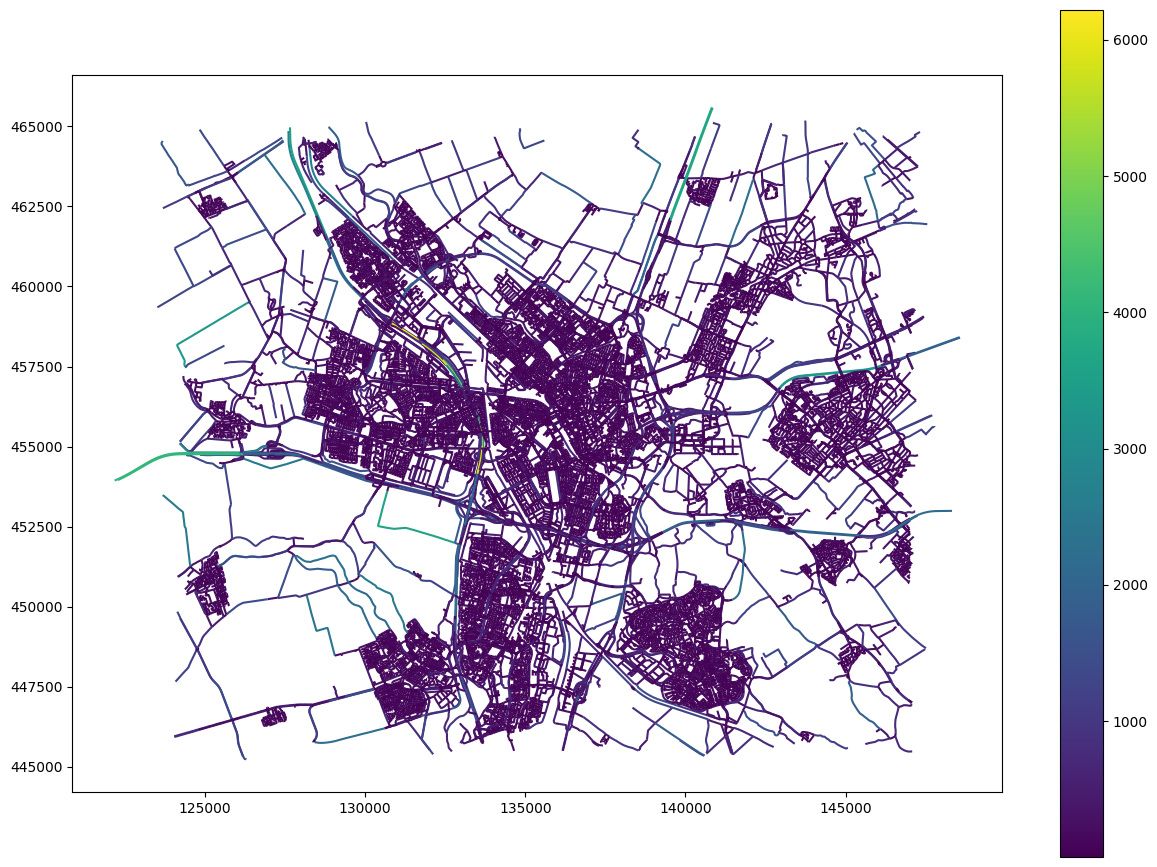

In [6]:
base = ut.plot(column = 'st_lengthshape'
        ,legend=True
        ,figsize=(15,11)
        )

In [10]:
# 2. Explode any MultiLineStrings into individual LineStrings
ut = ut.explode(index_parts=False).reset_index(drop=True)

# 3. Build the segment‐list column in one apply
def extract_segments(geom):
    """
    Given a LineString or (now exploded) single-part geometry,
    break it into a list of tiny LineStrings between each pair of coords.
    """
    coords = list(geom.coords)
    return [ LineString([coords[i], coords[i+1]]) 
             for i in range(len(coords)-1) ]

ut["segments"] = ut.geometry.apply(extract_segments)
ut.head()

,objectid,wvk_id,wvk_begdat,st_lengthshape,geometry,segments
0,96,600195776.0,2019-08-01 00:00:00+00:00,5.213405,"LINESTRING (141122.918 447780.379, 141127.735 ...",[LINESTRING (141122.91800000146 447780.3790999...
1,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",[LINESTRING (144609.83619999886 450717.9609000...
2,223,276315001.0,2020-12-01 00:00:00+00:00,247.420097,"LINESTRING (138180.068 457868.143, 138179.456 ...",[LINESTRING (138180.06799999997 457868.1433000...
3,230,291310030.0,2020-12-01 00:00:00+00:00,22.340021,"LINESTRING (145778.46 455101.553, 145783 45510...",[LINESTRING (145778.4598999992 455101.55319999...
4,239,267297164.0,2020-12-01 00:00:00+00:00,94.653877,"LINESTRING (133915.746 448769.847, 133909.864 ...",[LINESTRING (133915.74599999934 448769.8469999...


In [11]:

# 3. Explode so each row = one segment
segs = ut.explode("segments").reset_index(drop=True)
segs = segs.rename(columns={"segments": "geom"})
# 4. Vectorized extraction of endpoints and cost
#    (these are simple Series operations over the exploded GeoDataFrame)
segs["u"] = segs.geom.apply(lambda s: tuple(s.coords[0]))
segs["v"] = segs.geom.apply(lambda s: tuple(s.coords[-1]))
segs["weight"] = segs.geom.astype('geometry').apply(lambda x: x.length)
segs.head()

,objectid,wvk_id,wvk_begdat,st_lengthshape,geometry,geom,u,v,weight
0,96,600195776.0,2019-08-01 00:00:00+00:00,5.213405,"LINESTRING (141122.918 447780.379, 141127.735 ...",LINESTRING (141122.91800000146 447780.37909999...,"(141122.91800000146, 447780.3790999986)","(141127.73479999974, 447782.37359999865)",5.213405
1,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",LINESTRING (144609.83619999886 450717.96090000...,"(144609.83619999886, 450717.9609000012)","(144604.3302000016, 450716.6722000018)",5.654802
2,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",LINESTRING (144604.3302000016 450716.672200001...,"(144604.3302000016, 450716.6722000018)","(144601.79019999877, 450716.3546999991)",2.559767
3,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",LINESTRING (144601.79019999877 450716.35469999...,"(144601.79019999877, 450716.3546999991)","(144598.9327000007, 450717.78350000083)",3.194804
4,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",LINESTRING (144598.9327000007 450717.783500000...,"(144598.9327000007, 450717.78350000083)","(144592.90019999817, 450722.06969999894)",7.400173


In [12]:
# 5. Build the NetworkX graph in one shot
G = nx.from_pandas_edgelist(
    segs, 
    source="u", 
    target="v", 
    edge_attr=["weight", "geom"],
    create_using=nx.Graph()
)
G

In [13]:
poi = 133931.2,453062.0
station = 135989.6,455726.2

In [14]:

# Build KD-tree on node coordinates once
node_coords = np.array(list(G.nodes()))          # shape (N,2)
kdtree      = cKDTree(node_coords)

def nearest_node(pt):
    _, idx = kdtree.query(pt)
    return tuple(node_coords[idx])


# snap your two points
start = nearest_node(poi)
end   = nearest_node(station)

start


(np.float64(133917.48169999942), np.float64(453085.82129999995))

In [15]:

# compute shortest path (Dijkstra)
path = nx.shortest_path(G, source=start, target=end, weight="cost")

# stitch the segment geoms back together
route_segs = [ G[u][v]["geom"] for u,v in zip(path[:-1], path[1:]) ]
route_line = LineString([pt for seg in route_segs for pt in seg.coords])

# now you can wrap that in a GeoDataFrame, plot it, save it, etc.
route = gpd.GeoDataFrame({"id":[1]}, geometry=[route_line], crs="EPSG:28992")
# route.to_file("shortest_route.GeoJSON", driver='GEOJSON')
route

,id,geometry
0,1,"LINESTRING (133919.065 453087.032, 133917.482 ..."


<Axes: >

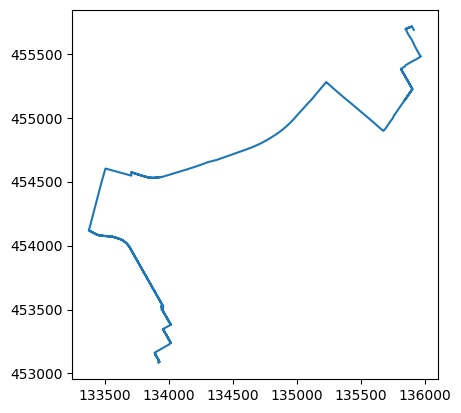

In [17]:
route.to_file('path2.geoJSON', driver = 'GEOJSON')
route.plot()

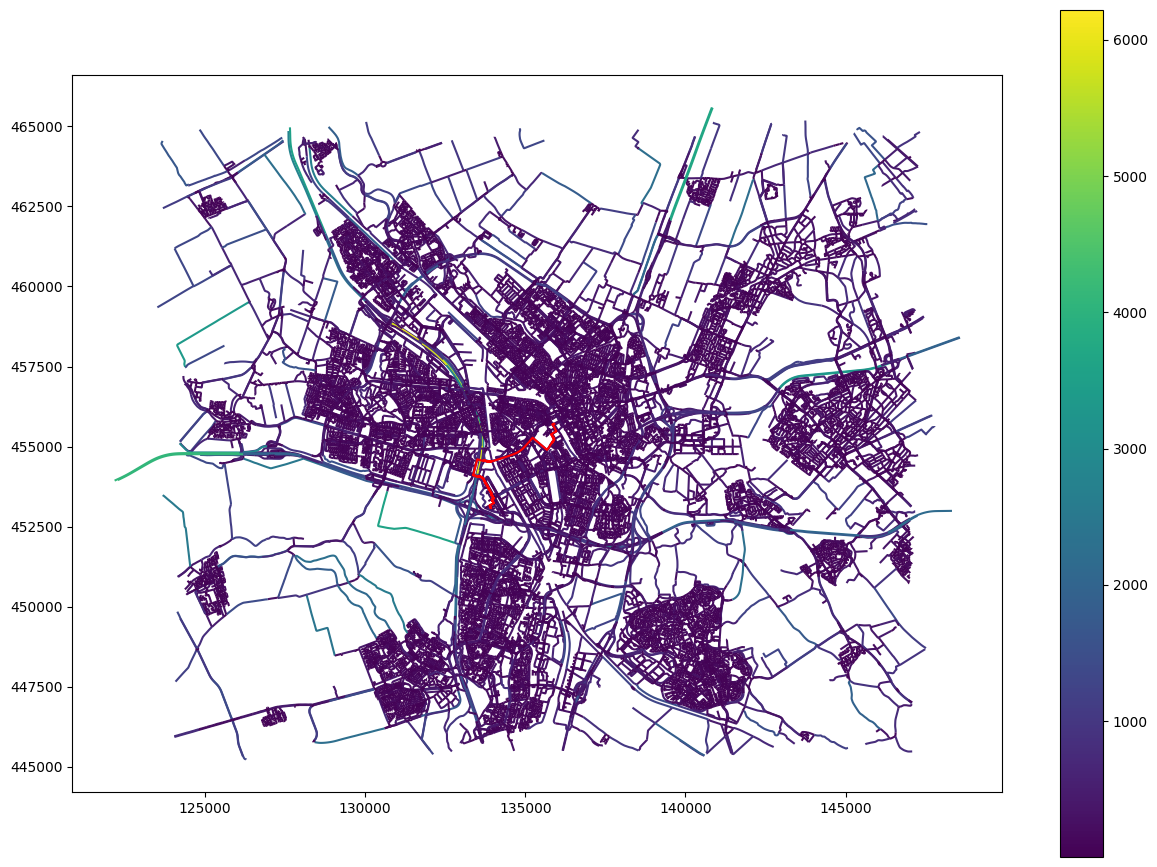

In [ ]:
base = ut.plot(column = 'st_lengthshape'
        ,legend=True
        ,figsize=(15,11)
        )
route.plot(color='red', ax=base)
plt.show()

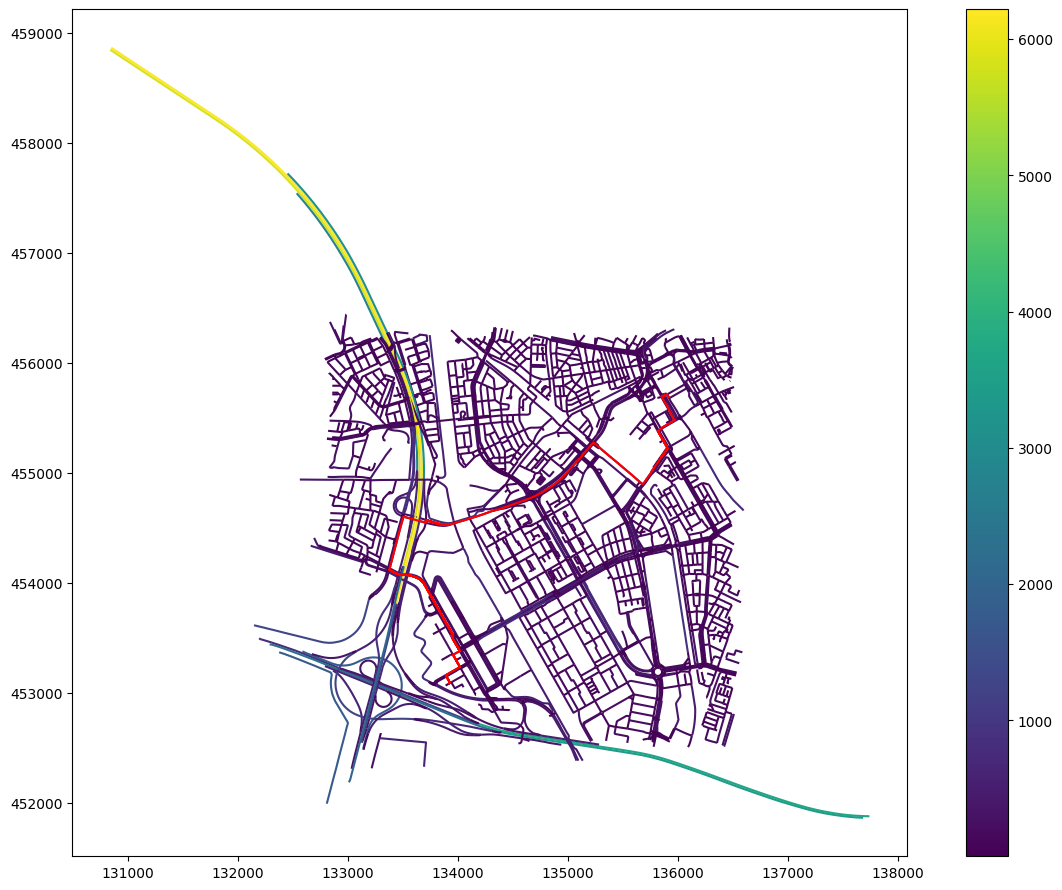

In [35]:
bounds = route.geometry.total_bounds #+ 2000

x = 500
bounds = bounds + [-x, -x, x, x]
base = ut.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]].plot(column = 'st_lengthshape'
        ,legend=True
        ,figsize=(15,11)
        )
route.plot(color='red', ax=base)
plt.show()

In [ ]:
# display interactive folium map

In [133]:
def interactive_map_notebook(df, df2):
    # Create a base folium map centered on df's centroid (or default location)
    centroid = df.geometry.union_all().centroid
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=6)
    # Add first GeoDataFrame to map with a blue style

    df_tooltip_fields = df.columns.tolist()
    df_tooltip_fields.remove('geometry')
    folium.GeoJson(
        df.__geo_interface__,
        name='Base Layer',
        style_function=lambda x: {'color': 'blue', 'weight': 1, 'fillOpacity': 0.4},
        tooltip=folium.GeoJsonTooltip(fields=df_tooltip_fields)
    ).add_to(m)
    # Add second GeoDataFrame to map with a red style
    df2_tooltip_fields = df2.columns.tolist()
    df2_tooltip_fields.remove('geometry')
    folium.GeoJson(
        df2.__geo_interface__,
        name='Overlay Layer',
        style_function=lambda x: {'color': 'red', 'weight': 3, 'fillOpacity': 0.4},
        tooltip=folium.GeoJsonTooltip(fields=df2_tooltip_fields)
    ).add_to(m)
    # Add layer control so you can toggle layers on/off
    folium.LayerControl().add_to(m)
    return m

In [142]:
# basedf = ut.drop(columns = ['wvk_begdat', 'segments'])
# interactive_map_notebook(basedf.to_crs(4326), route.to_crs(4326))